In [ ]:
! pip install evaluate transformers==4.52.1 rouge-score nltk
! pip install -U datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Transformers/Project/GQA_with_grouping')

In [ ]:
from datasets import load_dataset
from evaluate import load

raw_datasets = load_dataset("cnn_dailymail", "3.0.0")
metric = load("rouge")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
raw_datasets["train"] = raw_datasets["train"].shuffle(seed=42).select(range(1000))
raw_datasets["validation"] = raw_datasets["validation"].shuffle(seed=42).select(range(1000))
raw_datasets["test"] = raw_datasets["test"].shuffle(seed=42).select(range(1000))

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "/content/drive/MyDrive/technion/Trasformers/Project/GQA_with_grouping/fine_tune_CNN_DailyMail_3/checkpoint-5000"
model_weights = "/content/drive/MyDrive/technion/Trasformers/Project/GQA_with_grouping/fine_tune_CNN_DailyMail_3/checkpoint-5000/model.safetensors"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
max_input_length = 1024
max_target_length = 128
prefix = "summarize: "

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=examples["highlights"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
grouping_list_close_attention = [[0, 1, 2, 1, 0, 2],
                 [0, 1, 2, 1, 0, 2],
                 [0, 0, 2, 1, 1, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 1, 1, 2, 2, 0],
                 [0, 1, 0, 1, 2, 2],
                 [0, 1, 0, 2, 1, 2],
                 [0, 1, 2, 1, 0, 2],
                 [0, 1, 0, 1, 2, 2],
                 [0, 1, 0, 2, 1, 2],
                 [0, 1, 2, 1, 0, 2],
                 [0, 1, 2, 1, 2, 0],
                 [0, 1, 2, 1, 0, 2],
                 [0, 1, 2, 0, 1, 2],
                 [0, 1, 2, 2, 1, 0],
                 [0, 1, 2, 1, 0, 2]]

grouping_list_standard = [[0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2]]

assert len(grouping_list_standard) == 16

In [ ]:
import torch
from torch import nn
from safetensors.torch import load_file
from Init_T5_to_GQA import convert_t5_to_gqa, T5GQAAttention
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

kv_heads = 3
n_heads = 6

# Load the architecture (e.g., google/t5-v1_1-small)
model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-v1_1-small")
convert_t5_to_gqa(model.decoder, kv_heads=kv_heads, heads_grouping_arr=grouping_list_close_attention, inplace=True)

# Load the fine-tuned weights
state_dict = load_file(model_weights)
missing, unexpected = model.load_state_dict(state_dict, strict=False)
model.eval()

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Missing keys: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
Unexpected keys: []


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

def calc_sim_matrix(outs):
  layers_sim = []
  for layer_idx, score in enumerate(outs):
    score = score.squeeze(0).to(torch.device('cuda:0'))  # (n_heads, seq_len, d_kv)
    n_heads, seq_len, d_kv = score.shape

    sim_matrix = torch.zeros((n_heads, n_heads)).to(torch.device('cuda:0'))

    for t in range(seq_len):
        score_vectors = score[:, t, :]  # (n_heads, d_kv)
        score_norm = F.normalize(score_vectors, dim=1).to(torch.device('cuda:0'))  # normalize each head's vector

        cos_sim = torch.matmul(score_norm, score_norm.T).to(torch.device('cuda:0'))  # (n_heads, n_heads)
        sim_matrix += cos_sim

    # Average across sequence length
    sim_matrix /= seq_len
    sim_matrix_np = sim_matrix.cpu().numpy()
    layers_sim.append(sim_matrix_np)

  return layers_sim


def plot_layer_head_score_similarity(outs):
    # sim_matrixs = calc_sim_matrix(outs)

    for layer_idx, sim_mat in enumerate(outs):
        plt.figure(figsize=(6, 5))
        sns.heatmap(sim_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
                    xticklabels=[f"H{i}" for i in range(n_heads)],
                    yticklabels=[f"H{i}" for i in range(n_heads)])
        plt.title(f"Layer {layer_idx} - Head-to-Head K Cosine Similarity")
        plt.xlabel("Head")
        plt.ylabel("Head")
        plt.tight_layout()
        plt.show()


def calculate_model_score(model, input_ids, attention_mask):
  score_out = []
  def capture_k_hook(module, input, output):
      # input[0] shape - (batch, seq_len, d_model)
      hidden_states = input[0]
      k_proj = torch.nn.functional.linear(hidden_states, module.k.weight, module.k.bias if module.k.bias is not None else None)
      q_proj = torch.nn.functional.linear(hidden_states, module.q.weight, module.q.bias if module.q.bias is not None else None)

      d_kv = k_proj.shape[2] // n_heads
      q_proj = q_proj.view(q_proj.shape[0], -1, n_heads, d_kv).transpose(1, 2)
      k_proj = k_proj.view(k_proj.shape[0], -1, n_heads, d_kv).transpose(1, 2)

      k_proj = k_proj.repeat(1, 1, (n_heads // kv_heads), 1).reshape(k_proj.shape[0], n_heads, -1,
                                                                             d_kv)

      # score shape - (batch, n_heads, seq_len, seq_len)
      score = torch.matmul(q_proj, k_proj.transpose(3, 2))
      score_out.append(score.detach())

  hooks = []
  def register_hooks(module):
      if isinstance(module, T5GQAAttention):
          hooks.append(module.register_forward_hook(capture_k_hook))

  for name, module in model.decoder.named_modules():
      register_hooks(module)

  with torch.no_grad():
      model.to(torch.device('cuda:0'))
      model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=input_ids)

  for h in hooks:
      h.remove()

  print("Shape of first layer score:", score_out[0].shape)  # (1, num_heads, seq_len, head_dim)
  return score_out


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Shape of first layer score: torch.Size([1, 6, 2048, 2048])
Shape of first layer score: torch.Size([1, 6, 2048, 2048])
Shape of first layer score: torch.Size([1, 6, 814, 814])
Shape of first layer score: torch.Size([1, 6, 2048, 2048])
Shape of first layer score: torch.Size([1, 6, 944, 944])


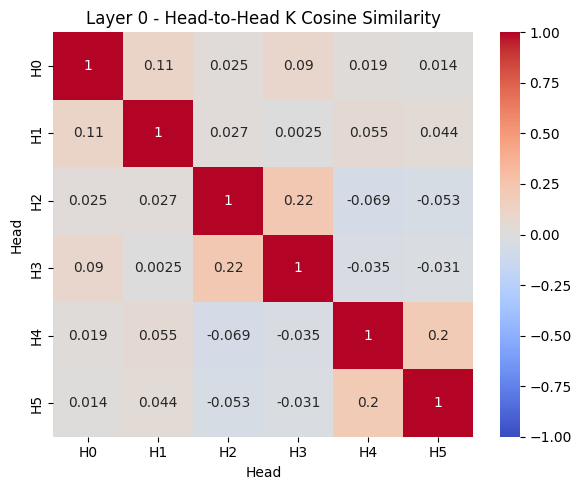

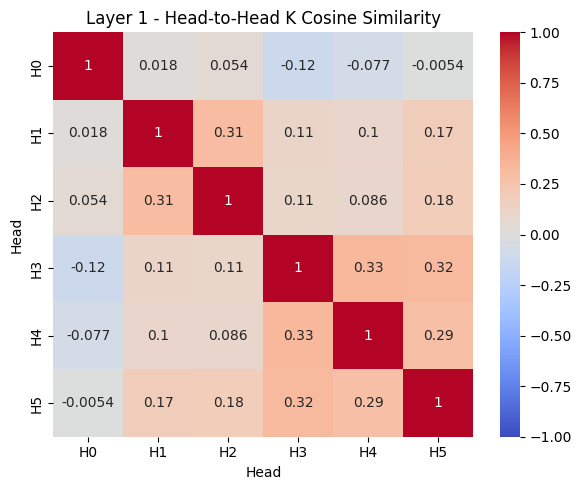

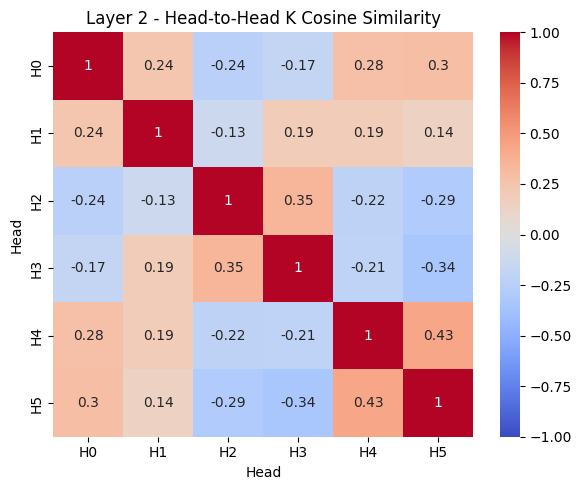

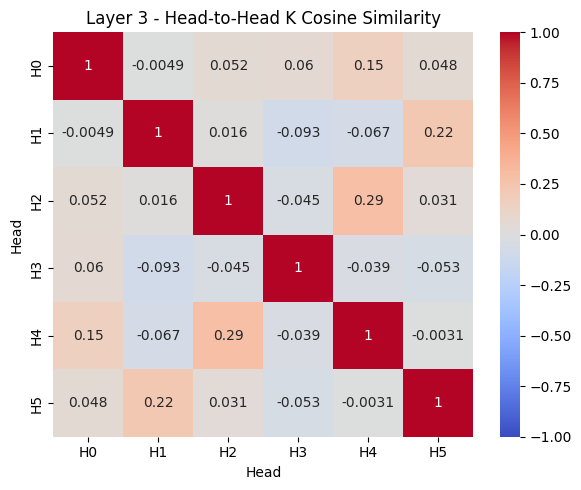

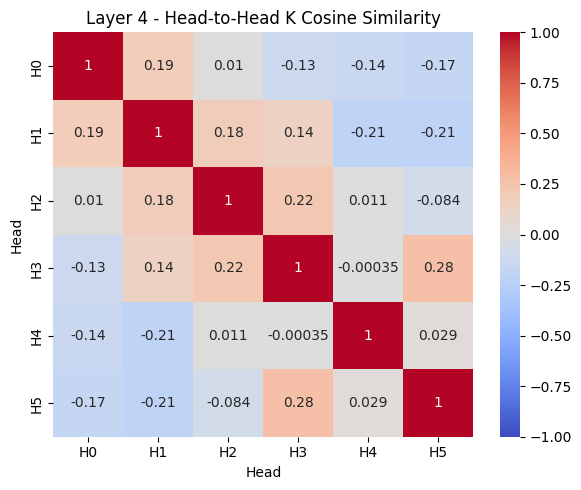

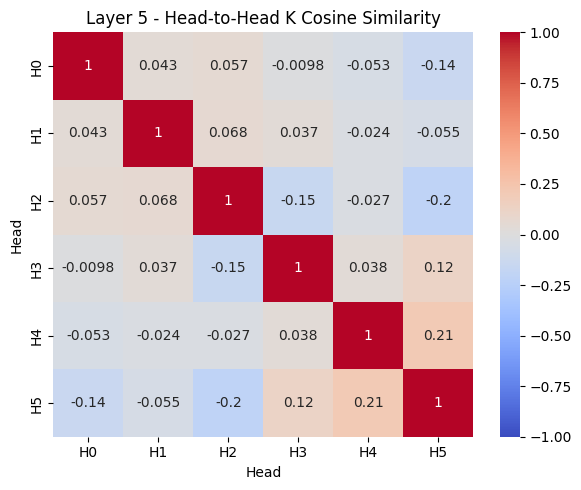

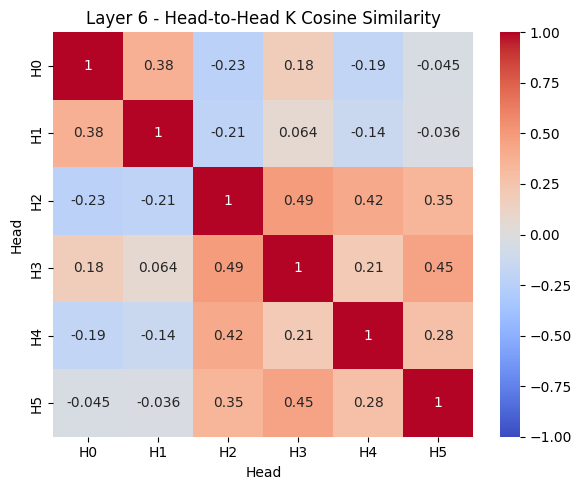

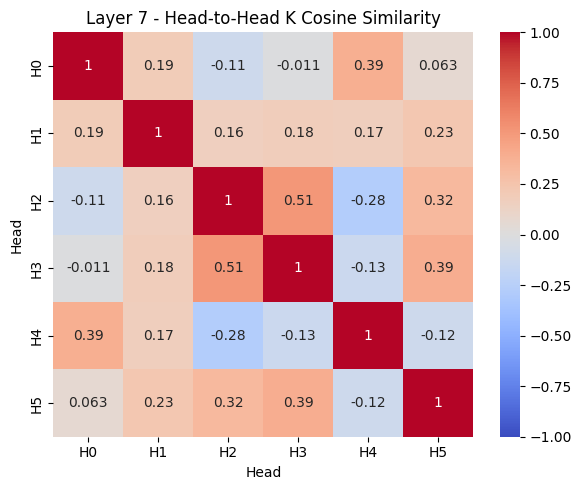

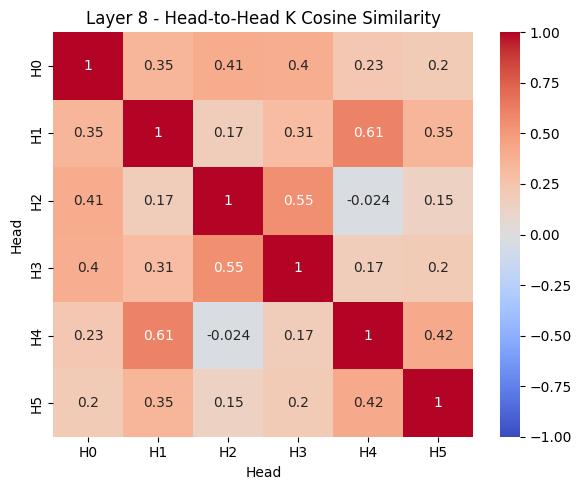

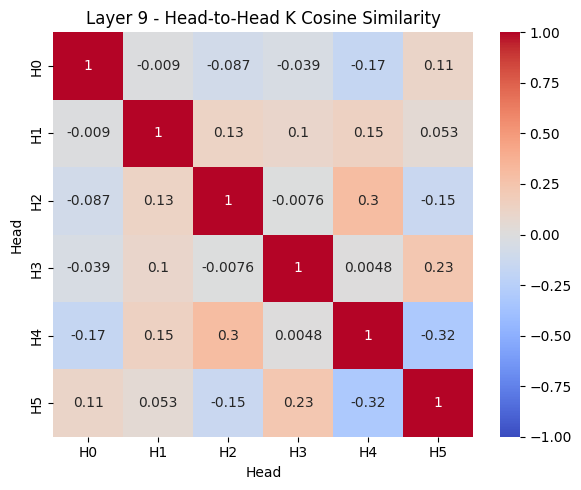

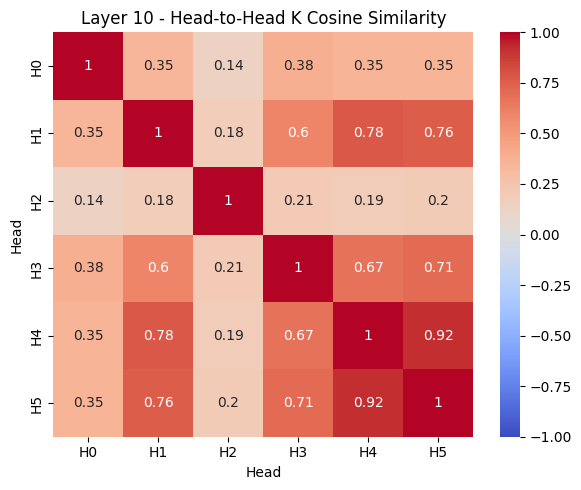

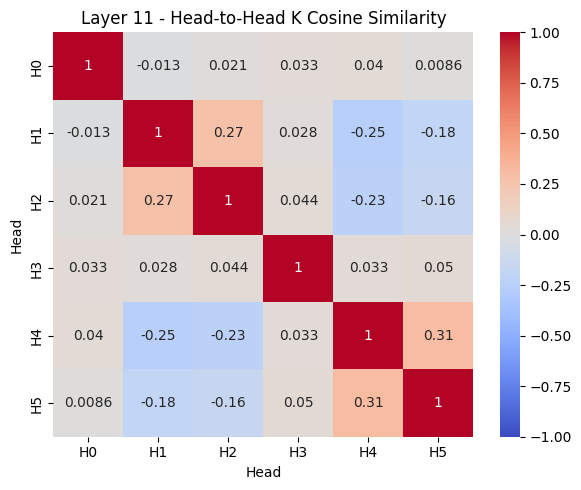

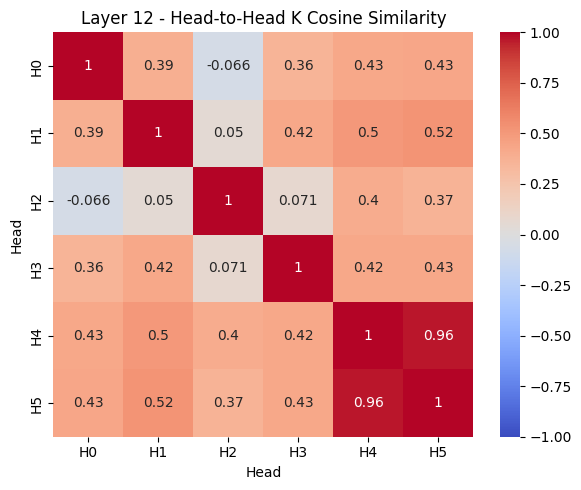

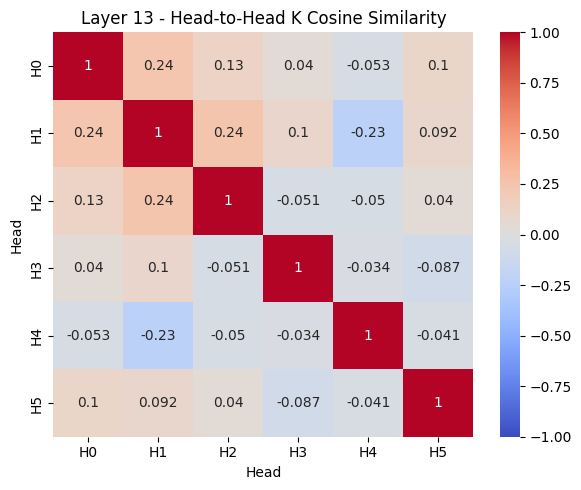

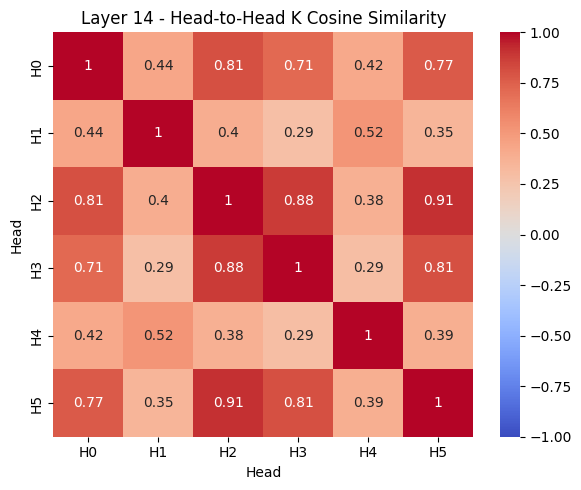

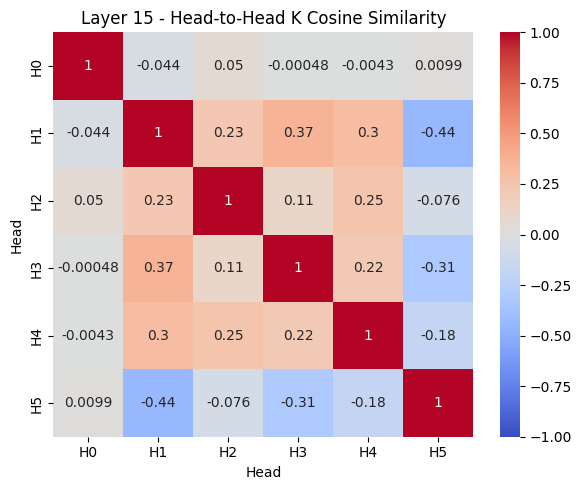

In [ ]:
import random

# Generate a list of unique random numbers
n = 5
examples = random.sample(range(1, 101), n)

total_sim_matrix = []

for idx in examples:
  sample = tokenized_datasets["validation"][idx]
  input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0).to(torch.device('cuda:0'))
  attention_mask = torch.tensor(sample["attention_mask"]).unsqueeze(0).to(torch.device('cuda:0'))
  layers_scores = calculate_model_score(model, input_ids, attention_mask)
  sim_matrixs = calc_sim_matrix(layers_scores)
  if total_sim_matrix == []:
    total_sim_matrix = sim_matrixs
  else:
    for mat_idx in range(len(total_sim_matrix)):
      total_sim_matrix[mat_idx] += sim_matrixs[mat_idx]

for mat_idx in range(len(total_sim_matrix)):
  total_sim_matrix[mat_idx] /= len(examples)

plot_layer_head_score_similarity(total_sim_matrix)

Shape of first layer score: torch.Size([1, 6, 85, 85])
Shape of first layer score: torch.Size([1, 6, 216, 216])
Shape of first layer score: torch.Size([1, 6, 684, 684])
Shape of first layer score: torch.Size([1, 6, 111, 111])
Shape of first layer score: torch.Size([1, 6, 574, 574])


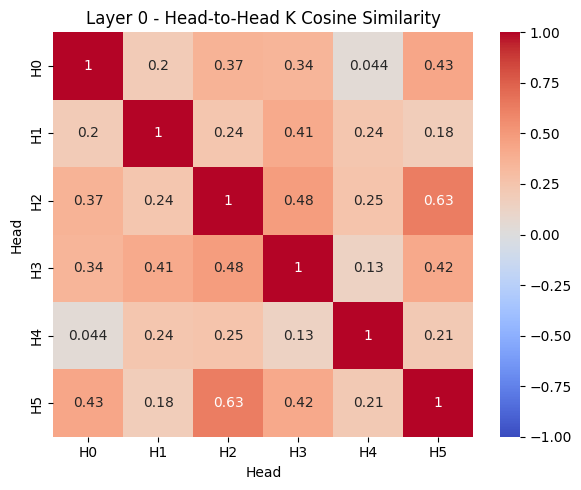

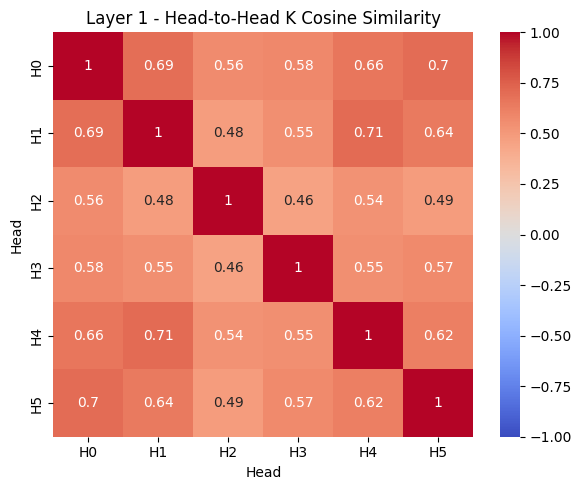

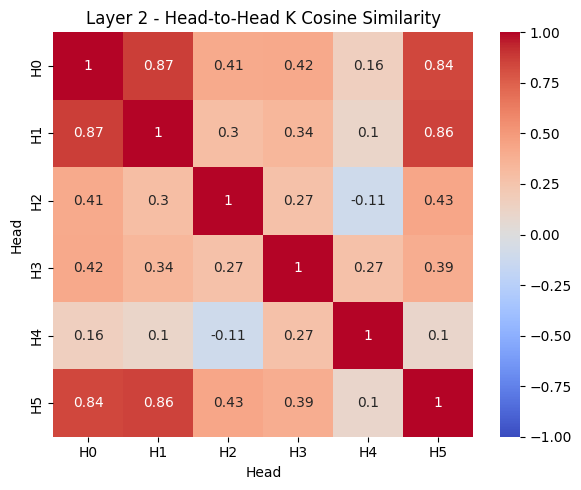

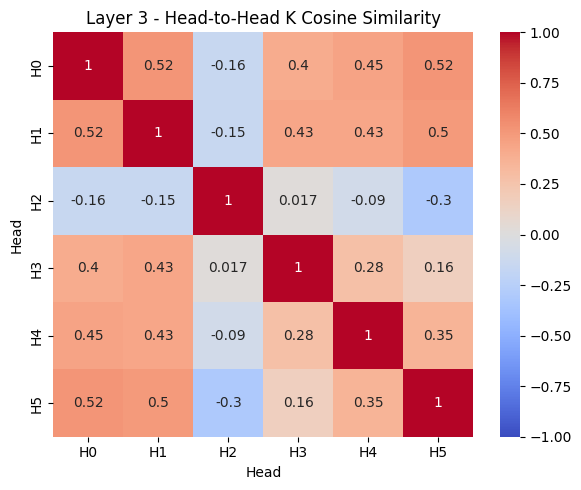

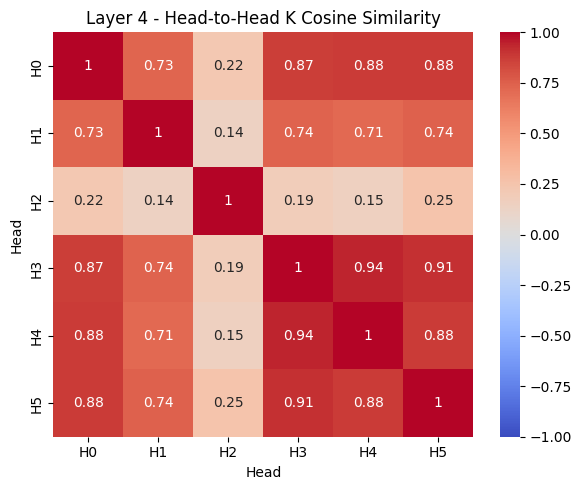

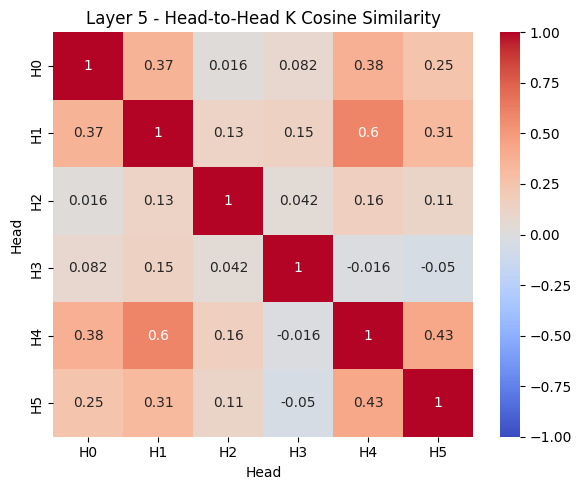

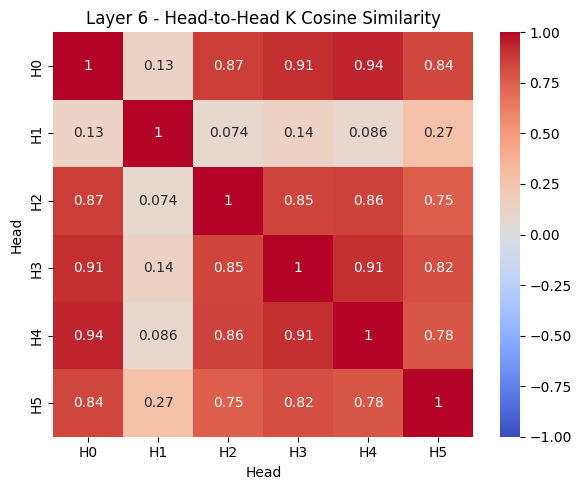

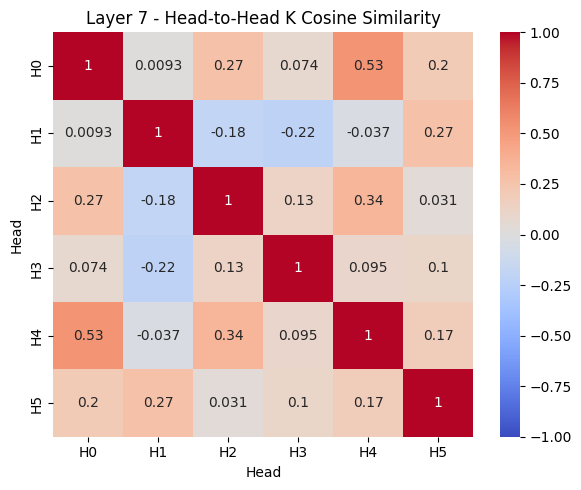

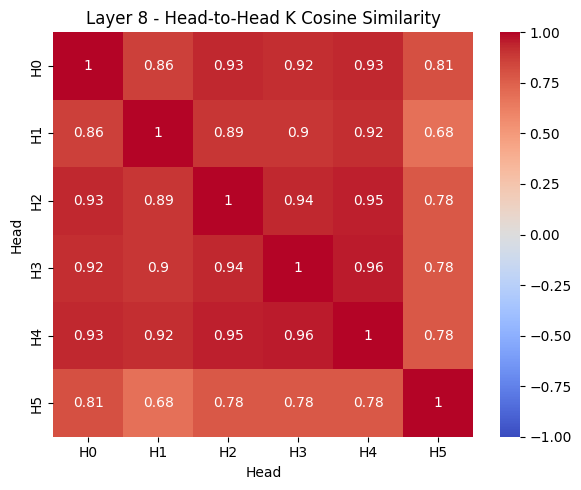

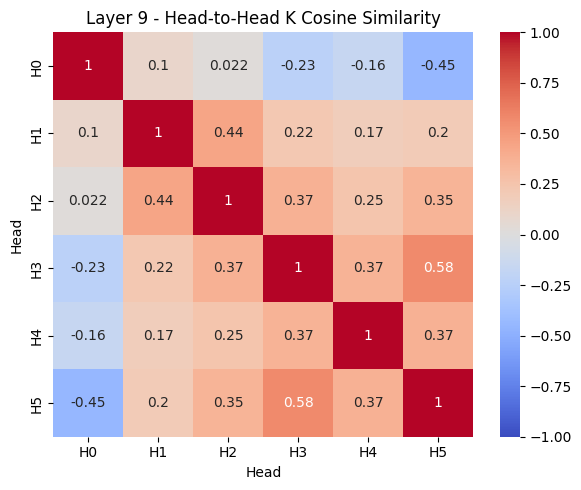

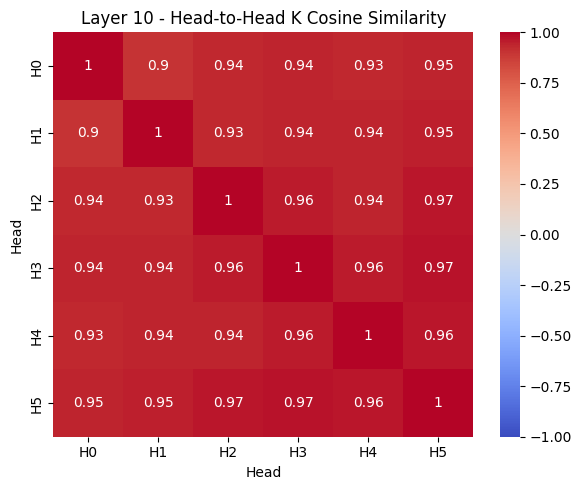

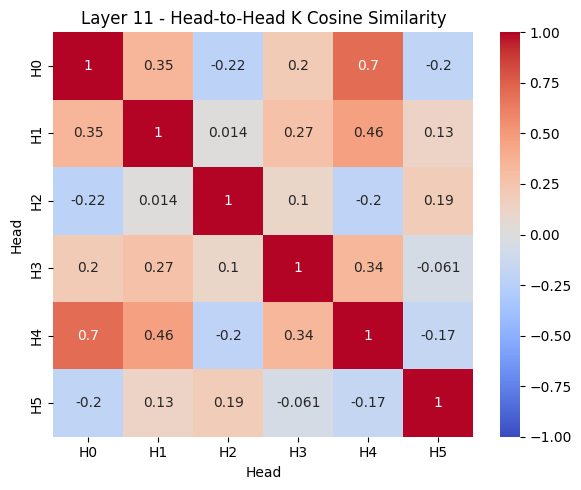

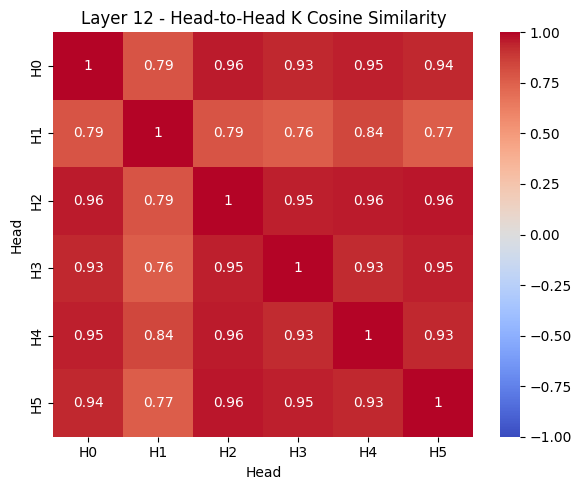

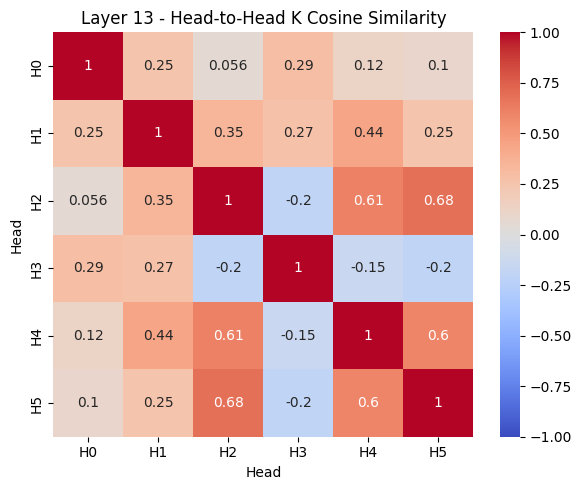

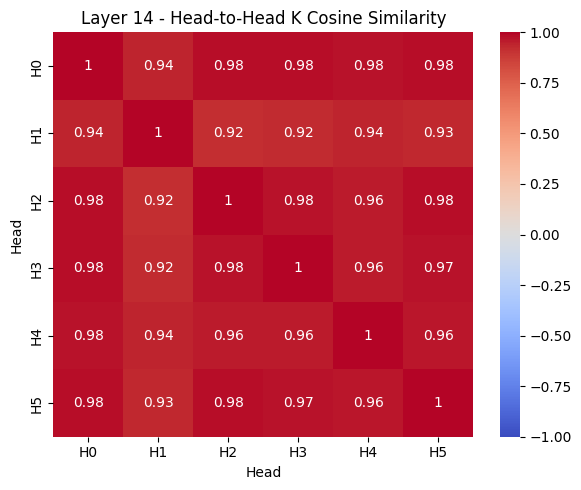

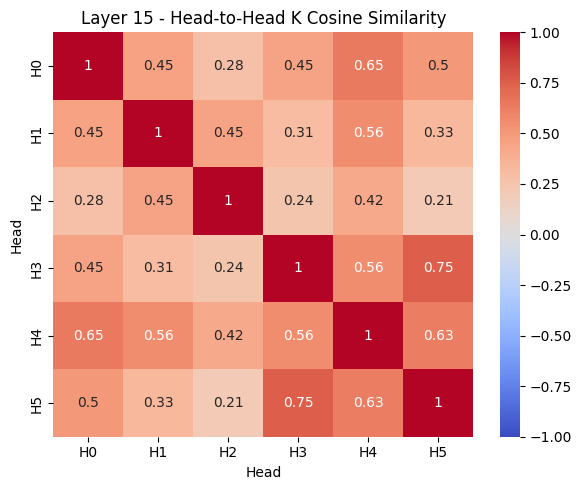

In [ ]:
import random

# Generate a list of unique random numbers
n = 5
examples = random.sample(range(1, 101), n)

total_sim_matrix = []

for idx in examples:
  sample = tokenized_datasets["validation"][idx]
  input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0).to(torch.device('cuda:0'))
  attention_mask = torch.tensor(sample["attention_mask"]).unsqueeze(0).to(torch.device('cuda:0'))
  layers_scores = calculate_model_score(model, input_ids, attention_mask)
  sim_matrixs = calc_sim_matrix(layers_scores)
  if total_sim_matrix == []:
    total_sim_matrix = sim_matrixs
  else:
    for mat_idx in range(len(total_sim_matrix)):
      total_sim_matrix[mat_idx] += sim_matrixs[mat_idx]

for mat_idx in range(len(total_sim_matrix)):
  total_sim_matrix[mat_idx] /= len(examples)

plot_layer_head_score_similarity(total_sim_matrix)

# **Check if model was loaded correctly**

In [ ]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from transformers import TrainerCallback
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)
    result = {key: value * 100 for key, value in result.items()}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
batch_size = 8
args = Seq2SeqTrainingArguments(
    output_dir=f"/content/drive/MyDrive/technion/Trasformers/Project/fine_tune_Xsum_{kv_heads}",
    eval_strategy = "epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=1,
    logging_dir="/content/drive/MyDrive/technion/Trasformers/Project/logs",
    logging_steps=100,
    predict_with_generate=True,
    report_to="none"
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

test_results = trainer.predict(tokenized_datasets["test"].select(range(50)))

# Print ROUGE-1 (and optionally others)
print("Test set ROUGE scores:")
print(f"ROUGE-1: {test_results.metrics['test_rouge1']:.2f}")

/tmp/ipython-input-14-1125579252.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Test set ROUGE scores:
ROUGE-1: 23.42
